In [1]:
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
import statsmodels
from scipy.special import expit

In [2]:
plt.rcParams["figure.figsize"] = (14, 8)

In [3]:
df = pd.read_csv('spy.txt')
spy = pd.Series(list(df['return']), index=pd.to_datetime(df['date']))#.asfreq('D', 'pad')

df = pd.read_csv('spy1m.txt')
spy1m = pd.Series(list(df['return']), index=pd.to_datetime(df['date']), name='data').asfreq('M', 'pad')

spy1w = np.expm1(np.log1p(spy).resample('W').sum())

spy = pd.Series(spy.values, index=spy.index.tz_localize(None))
spy1m = pd.Series(spy1m.values, index=spy1m.index.tz_localize(None))

In [6]:
def run(xs, order):
    df = xs.to_frame() 
    win = 96
    import warnings
    warnings.filterwarnings("ignore")
    mod = tsa.SARIMAX(df[:win], order=(1, 0, 1))
    res = mod.fit()
    fcasts = []
    fcasts.append(res.forecast())
    
    for i in range(win, len(df)):
        res = res.append(df.iloc[i:i+1], refit=True)
        fcasts.append(res.forecast())
    fcs = pd.concat(fcasts)
    fcs.plot(label='Forecasted S&P 500 Return').legend()
    xs[xs.index >= fcs.index[0]].plot(label='S&P 500 Return').legend()
    y_pred = fcs
    y_true = xs[xs.index >= fcs.index[0]] 
    ys = (y_true * y_pred > 0).value_counts().values
    print('Corr', xs.corr(fcs))
    print('Accuracy', ys[0]/sum(ys))
    
    return fcs

Corr -0.15410699592792768
Accuracy 0.5504587155963303


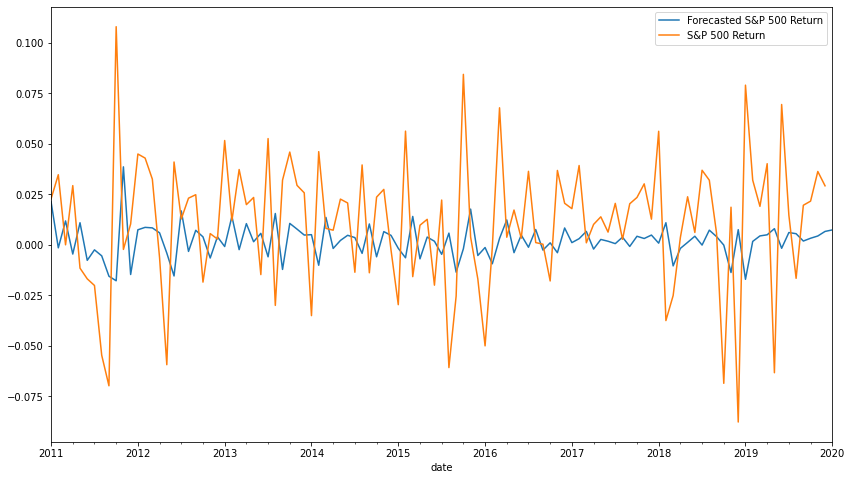

In [7]:
arma_rets = run(spy1m, (1, 0, 1))

In [8]:
am = arch_model(spy, rescale=True, dist='t')
index = spy.index
start_loc = 0
end_loc = 63
forecasts = {}
for i in range(len(spy) - end_loc):
    res = am.fit(first_obs=0, last_obs=i + end_loc, disp='off')
    temp = np.sqrt(res.forecast(horizon=1).variance)
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast

In [15]:
ret_fcs = pd.Series(arma_rets.values, index=arma_rets.index.tz_localize(None))
garch_vols = np.sqrt(21)*(pd.DataFrame(forecasts).T / am.scale).shift(1)['h.1']
vol_fcs = garch_vols[garch_vols.index >= ret_fcs.index[0]]

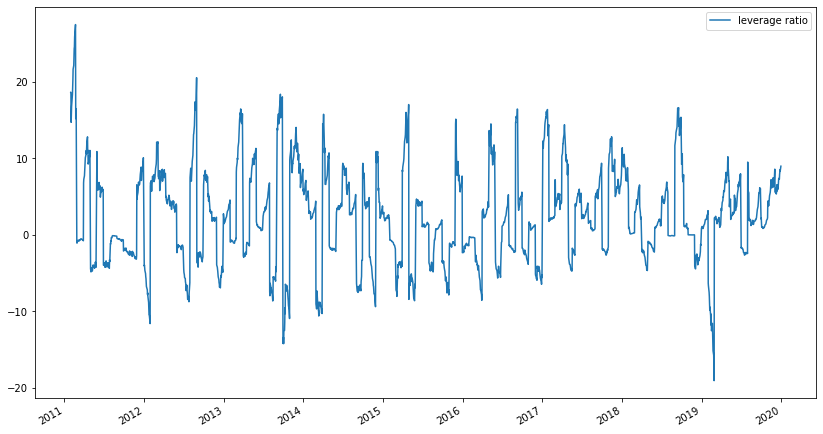

In [23]:
lev = (ret_fcs.asfreq('D', method='ffill') / (vol_fcs**2)).dropna()
lev.plot(label='leverage ratio').legend()

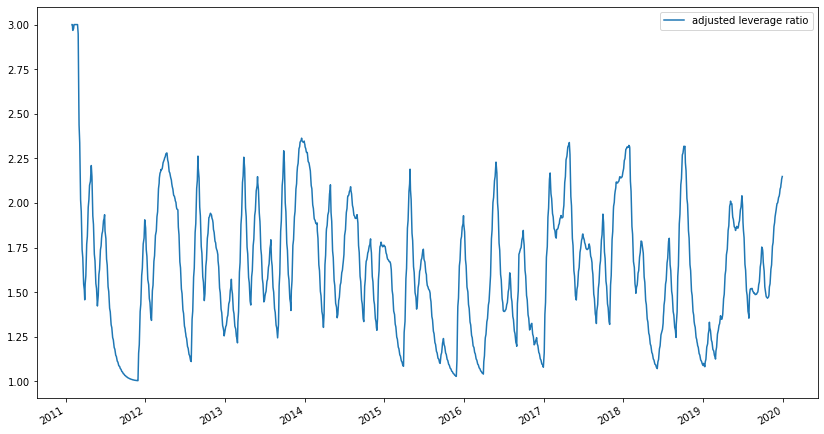

In [57]:
lev = (ret_fcs.asfreq('D', method='ffill') / (vol_fcs**2)).dropna()
lev[lev <= 1.0] = 0
lev = np.log(np.e+lev).ewm(alpha=0.05).mean()
lev[lev >= 3.0] = 3.0
lev.plot(label='adjusted leverage ratio').legend()

In [26]:
spy = spy[spy.index >= lev.index[0]]

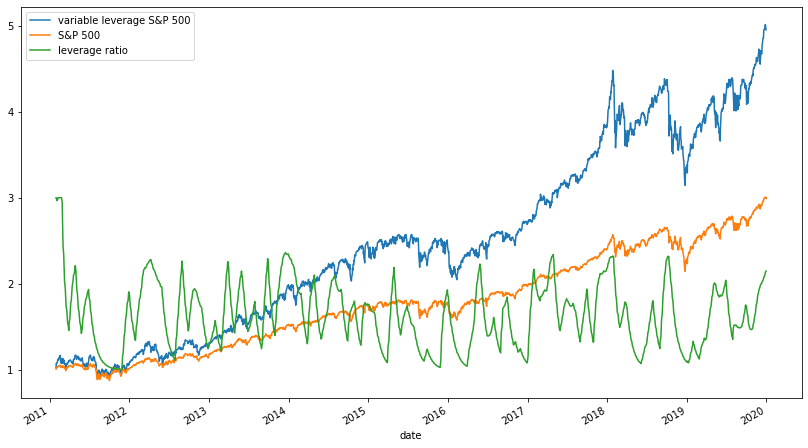

In [62]:
(1 + lev * spy).cumprod().plot(label='variable leverage S&P 500').legend()
(1 + spy).cumprod().plot(label='S&P 500').legend()
lev.plot(label='leverage ratio').legend()